In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [4]:
import cupy as cp

In [5]:
PROJECT_PATH = '../'
PCP_PATH = '/scratch/ceph/szalay/swei20/AE/PCP_HM.h5'
PCP20_PATH = '/scratch/ceph/szalay/swei20/AE/PCP_FLUX_HM20.h5'
NORM_PATH = "/scratch/ceph/szalay/swei20/AE/norm_flux_step4.h5"
sys.path.insert(0, PROJECT_PATH)

In [6]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

### Load data

In [7]:
with h5py.File(NORM_PATH, 'r') as f:
    flux0 = f['flux'][()]
    para0 = f['para'][()]
    wave0 = f['wave'][()]

In [8]:
flux0.shape, wave0.shape

((116614, 3850), (3850,))

In [9]:
from lv.base.dataloader_c import DataLoader

In [10]:
ds = DataLoader()

In [11]:
ds.prepare_data (flux0, wave0, para0, "H", "M", fix_CO=0)

Cupy flux: 80442, wave: 1175


In [20]:
mask0=ds.get_major(k=5, q=0.6, niter=2)

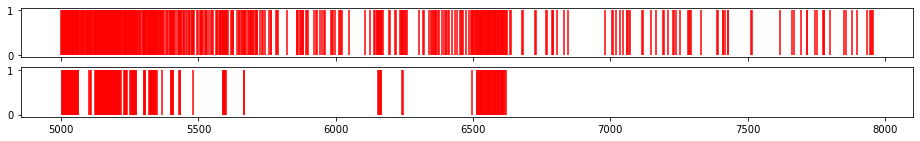

In [21]:
ds.plot_eroded_mask(mask0)

In [22]:
ds.get_MN(ds.mask, top=5)

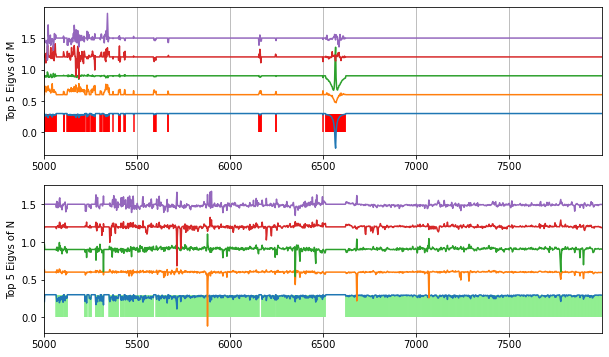

In [23]:
f, axs = plt.subplots(2,1,figsize=(10,6))
ds.plot_MN(step=0.3, axs=axs)

In [24]:
ML, MS, MLv, MSv = ds._pcp(ds.M, delta=1e-6, mu=None, lam=None, norm=None, maxiter=500)

46.00914 0.003525807279719099 113565.13


In [25]:
paraa = ds.dfpara.values

In [26]:
with h5py.File(PCP_PATH, 'w') as f:
    f.create_dataset("flux", data=cp.asnumpy(ds.flux), shape=ds.flux.shape)
    f.create_dataset("wave", data=cp.asnumpy(ds.wave), shape=ds.wave.shape)
    f.create_dataset("para", data=paraa, shape=paraa.shape) 
    f.create_dataset("ML", data=cp.asnumpy(ML), shape=ML.shape)
    f.create_dataset("MS", data=cp.asnumpy(MS), shape=MS.shape)
    f.create_dataset("MLv", data=cp.asnumpy(MLv), shape=MLv.shape) 
    f.create_dataset("MSv", data=cp.asnumpy(MSv), shape=MSv.shape) 

    

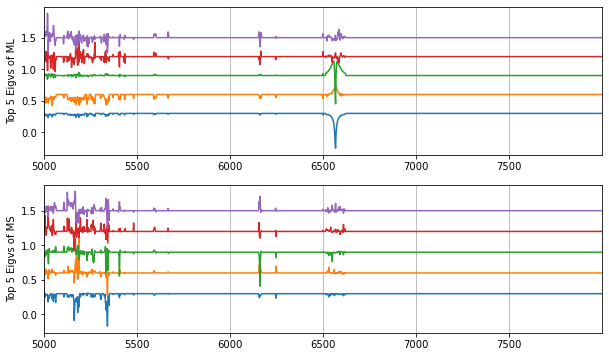

In [27]:
f, axs = plt.subplots(2,1,figsize=(10,6), facecolor="w")
ds.plot_eigv(MLv, name="ML", ax=axs[0])
ds.plot_eigv(MSv, name="MS", ax=axs[1])

In [28]:
NL, NS, NLv, NSv = ds._pcp(ds.N, delta=1e-6, mu=None, lam=None, norm=None, maxiter=500)

55.91488 0.003525807279719099 22818.379


In [29]:
with h5py.File(PCP_PATH, 'a') as f:
    f.create_dataset("NL", data=cp.asnumpy(NL), shape=NL.shape)
    f.create_dataset("NS", data=cp.asnumpy(NS), shape=NS.shape)
    f.create_dataset("NLv", data=cp.asnumpy(NLv), shape=NLv.shape) 
    f.create_dataset("NSv", data=cp.asnumpy(NSv), shape=NSv.shape) 

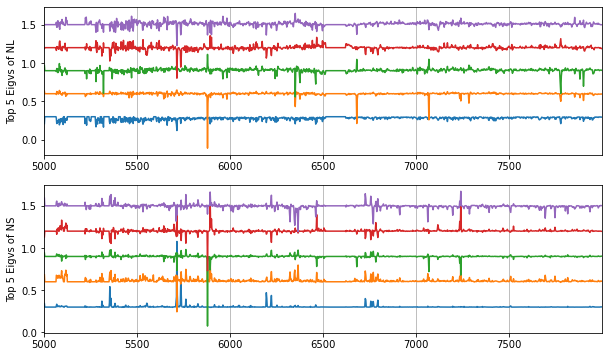

In [30]:
f, axs = plt.subplots(2,1,figsize=(10,6), facecolor="w")
ds.plot_eigv(NLv, name="NL", ax=axs[0])
ds.plot_eigv(NSv, name="NS", ax=axs[1])

In [31]:
pcp20 = cp.vstack([MLv[:5],MSv,NLv[:5],NSv])

In [32]:
pcp20.shape

(20, 1175)

In [33]:
flux20 = cp.dot(ds.flux, pcp20.T)

In [34]:
flux20.shape

(80442, 20)

In [35]:
nflux20 = cp.asnumpy(flux20)

In [36]:
with h5py.File(PCP20_PATH, 'w') as f:
    f.create_dataset("flux", data=nflux20, shape=nflux20.shape)
    f.create_dataset("para", data=paraa, shape=paraa.shape)    

In [37]:
for i in range(20):
    ds.dfpara[f"p{i}"] = nflux20[:,i]

In [38]:
df = ds.dfpara

In [39]:
import seaborn as sns

In [40]:
PP = [f"p{i}" for i in range(20)]

In [ ]:
sns.pairplot(
    df,
    x_vars=PP,
    y_vars=PP,
    hue="T",
    plot_kws=dict(marker="o", s=2, edgecolor="none"),
    diag_kws=dict(fill=False),
    palette="gist_rainbow",
    corner=True
)

In [ ]:
sns.pairplot(
    df,
    x_vars=[f"p{i}" for i in range(20)],
    y_vars=[f"p{i}" for i in range(20)],
    hue="L",
    plot_kws=dict(marker="o", s=2, edgecolor="none"),
    diag_kws=dict(fill=False),
    palette="winter",
    corner=True
)

In [ ]:
sns.pairplot(
    df,
    x_vars=[f"p{i}" for i in range(20)],
    y_vars=[f"p{i}" for i in range(20)],
    hue="F",
    plot_kws=dict(marker="o", s=2, edgecolor="none"),
    diag_kws=dict(fill=False),
    palette="terrain",
    corner=True
)

In [ ]:
df